<a href="https://colab.research.google.com/github/paripatel55/DatabaseProject/blob/main/Copy_of_Data_Science_Collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Data Preprocessing**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import pymc as pm
import arviz as az
import networkx as nx
from scipy import stats

# utility function for standardizing variables
def standardize(series):
    return (series - series.mean()) / series.std()

df = pd.read_csv("dataset.csv")
df = df.dropna(subset=["energy", "popularity", "track_genre"]) # specific columns considered

# keep top 15 genres
top_genres = df["track_genre"].value_counts().nlargest(15).index
df["track_genre"] = df["track_genre"].apply(lambda g: g if g in top_genres else "Other")
df["genre_id"] = df["track_genre"].astype("category").cat.codes
num_genres = df["genre_id"].nunique()

# standardize large values
df["energy_scaled"] = standardize(df["energy"])
df["popularity_scaled"] = standardize(df["popularity"])


## **Introduction:**

The "dataset.csv" file contains information about various songs, exploring properties like genre, popularity, apparent energy levels, and more. Specifically, energy level ranges from a coefficient value of 0.0 to 1.0. Popularity ranges from a value of 0.0 to 100.0. There are 125+ unique genres of music in this dataset assigned with each track. Additionally, confounding factors may impact the relation between energy and popularity, such as the genre of a song. The top 15 genres with the most songs associated with it will be analyzed, while the remaining will be mapped to “Other”. This is to reduce the number of unique but infrequent genres to improve interpretability. In this, we will explore potential relationships between energy levels and the popularity of a song.

**We want to answer the question of:**
Does the energy level of a track influence the popularity of it?
When accounting for the confound “Genre”, how does energy influence popularity in each genre?

**DAG**

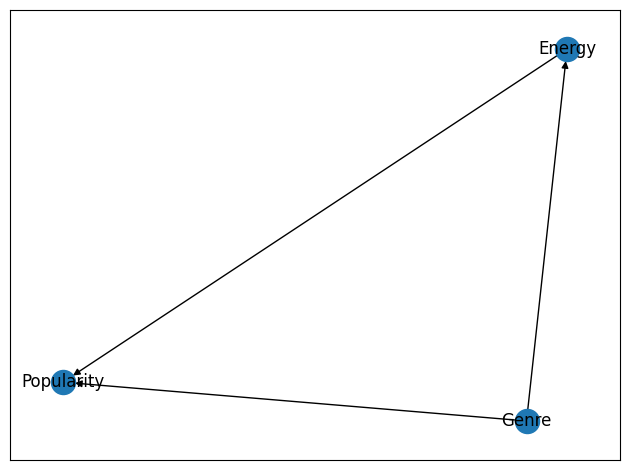

In [ ]:
graph = nx.DiGraph()
graph.add_edges_from([("Genre", "Energy"), ("Energy", "Popularity"), ("Genre", "Popularity")])
nx.draw_networkx(graph, arrows=True)
plt.tight_layout()



**Causal Model Description:**

The relationship can be visualized from the DAG above.
Energy influences the Popularity of a track.
Genre influences the Popularity of a track.
Genre influences the Energy of a track.
These will be used to analyze if Energy influences the Popularity of a track, accounting for the Genre of each track.

## **Prior Predictive Simulation**

**Justify prior from outside resource:**

We chose a Normal(0,1) prior for the intercept to show uncertainty about the baseline level of popularity across genres. This prior is flexible allowing the model to adapt to different popularity levels.  

We chose a Normal(0,0.5) prior for the slope of energy on popularity to represent a weak belief that energy may influence popularity and with mean of 0 to show uncertainty about the direction of the effect on popularity. These weak priors will allow for a wide range of outcomes, like positive, negative, or none.

This prior choice is supported by a study done by Singh (2024), who found a positive coefficient of 0.12 for energy in a linear model predicting Spotify track popularity.

Here is her study: https://medium.com/%40akankshalksingh/analyzing-spotify-track-popularity-using-python-d5513eddb300

> **Prior Predictive Model (Mathematical Notation)**
>
> We define a prior predictive model to evaluate the plausibility of outcomes before incorporating observed data. The distributions are:
>
> $$
> \alpha \sim \mathcal{N}(0, 1), \quad
> \beta \sim \mathcal{N}(0, 0.5), \quad
> \mu_i = \text{logistic}(\alpha + \beta E_i)
> $$
>
> where:
>
> - $E_i$ is the standardized energy value for observation $i$  
> - $\mu_i$ is the expected popularity from bounds [0,1]
>
> This model excludes observed data to simulate outcomes under our prior assumptions.


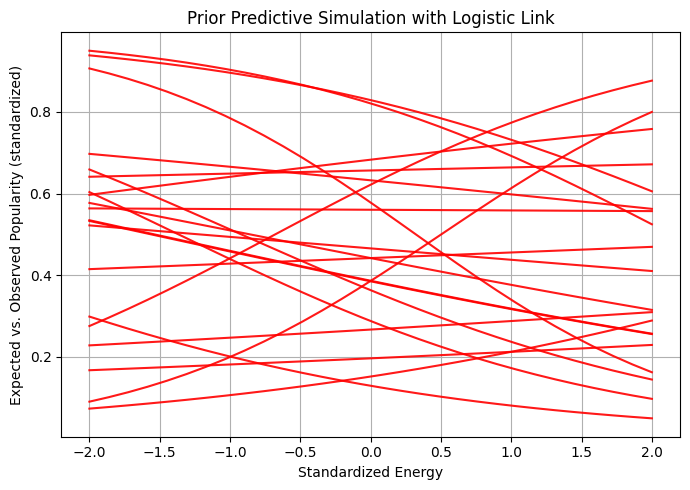

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from scipy import stats

# approximate range of standardized energy values
energy_seq = np.linspace(-2, 2, 30)

# logit scale popularity
popularity_logit = expit(popularity_vals)

# sample 20 prior alpha and beta values
np.random.seed(42)
alpha_samples = stats.norm.rvs(0, 1, size=20)
beta_samples = stats.norm.rvs(0, 0.5, size=20)

# plot the logistic curves from the priors
plt.figure(figsize=(7, 5))
for i in range(len(alpha_samples)):
    mu_logit = alpha_samples[i] + beta_samples[i] * energy_seq
    mu = expit(mu_logit)  # logistic transformation
    plt.plot(energy_seq, mu, color='red', alpha=0.9)

plt.xlabel("Standardized Energy")
plt.ylabel("Expected vs. Observed Popularity (standardized)")
plt.title("Prior Predictive Simulation with Logistic Link")
plt.grid(True)
plt.tight_layout()
plt.show()

**Justification of the prior:**

The prior predictive simulation manually samples 20 combinations of alpha ~Normal(0,1) and beta ~Normal(0,0.5) and uses them to generate logistic curves over an approximated range of standardized energy values.

The curves, shown in red in the plot above, span a wide variety of trends, including flat, decreasing, and increasing patterns. The priors are flexible and can show various relationships between energy and population.

## **Posterior Predictive Simulation on manually selected values:**


**Statistical Model (Mathematical Notation)**

We simulate a dataset to test the model’s ability to recover parameters. The assumed data-generating process is:

$$
E_i \sim \text{Beta}(1, 1), \quad
\mu_i = \text{logistic}(\alpha + \beta E_i), \quad
P_i \sim \mathcal{N}(\mu_i, \sigma)
$$
where:

$$
\begin{aligned}
\alpha &= 0.5 \\
\beta &= 0.3 \\
\sigma &= 0.4 \\
N &= 100 \text{ observations}
\end{aligned}
$$





This simulated model helps us verify whether the Bayesian inference procedure can recover known parameter values.


Output()

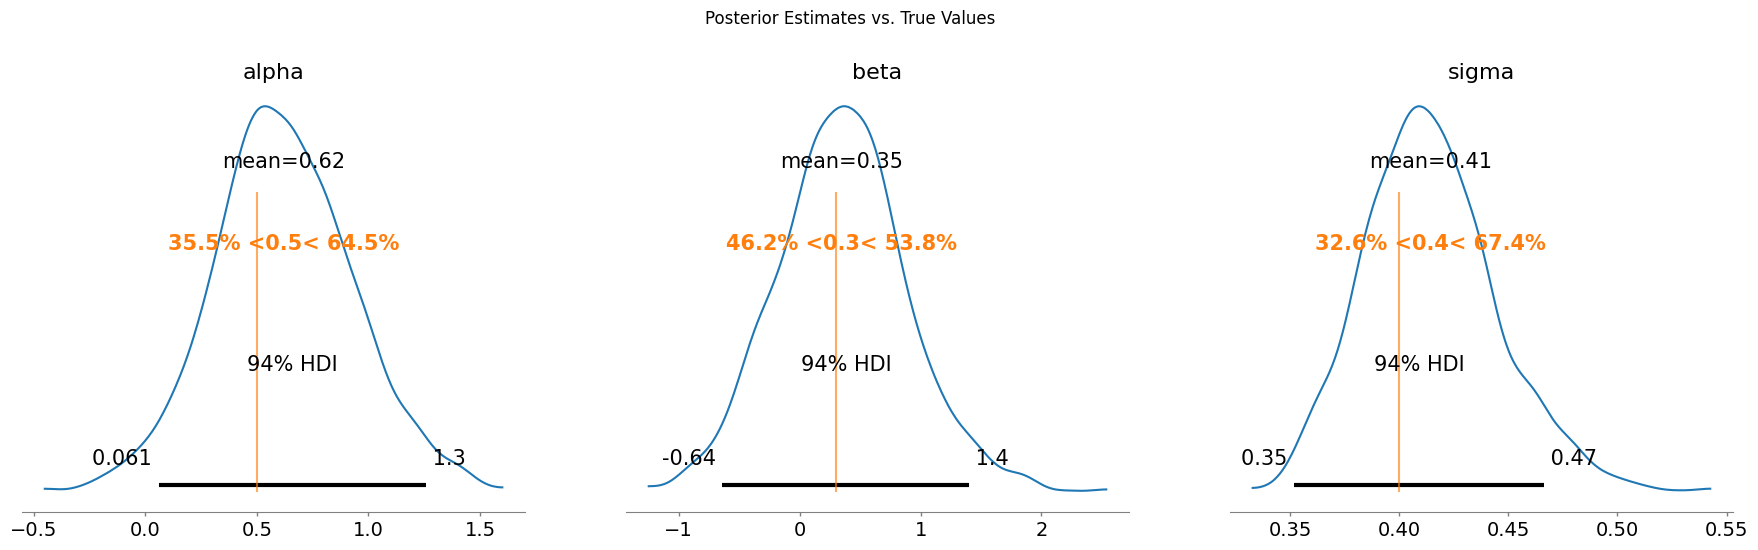

In [ ]:
# simulate data using manually selected values
alpha_true = 0.5
beta_true  = 0.3
sigma_true = 0.4

N = 100

sim_energy = stats.beta.rvs(a=1, b=1, size=N)

mu_logit = alpha_true + beta_true * sim_energy
mu       = 1 / (1 + np.exp(-mu_logit))


sim_popularity = stats.norm.rvs(loc=mu, scale=sigma_true, size=N)


df_sim = pd.DataFrame({
    "energy":     sim_energy.astype("float32"),
    "popularity": sim_popularity.astype("float32")
})

# model on simulated data
with pm.Model() as sim_model:
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta  = pm.Normal("beta",  mu=0, sigma=1)
    sigma = pm.Exponential("sigma", 1)

    mu_logit = alpha + beta * df_sim["energy"].values
    mu       = pm.Deterministic("mu", pm.math.invlogit(mu_logit))

    y_obs = pm.Normal("popularity", mu=mu, sigma=sigma,
                      observed=df_sim["popularity"].values)

    sim_trace = pm.sample(1000, tune=1000, return_inferencedata=True,
                          random_seed=42)

az.plot_posterior(sim_trace, var_names=["alpha", "beta", "sigma"],
                  ref_val=[0.5, 0.3, 0.4])
plt.suptitle("Posterior Estimates vs. True Values", y=1.02)
plt.show()

# plot table

**Posterior Predictive Simulation on manually simulated data:**

In this section, we simulate energy and popularity values using predefined parameter values. The simulated dataset is then analyzed using the Bayesian model, and the resulting posterior estimates are compared against the true values used in the simulation. As can be seen from the graph, the center values for alpha, beta, and sigma of the distribution are 0.62, 0.35, and 0.41, respectively—very close to the predefined parameter that we set. This suggests that the manually chosen values of alpha = 0.5, beta = 0.3, and sigma = 0.4 are successfully recovered, indicating that the model can accurately infer the true parameters.




## **Posterior Predictive Simulation on Real Data**

**Statistical Model (Mathematical Notation)**:

$$
\text{logit}(\mu_i) = \alpha_{g[i]} + \beta_{g[i]} E_i
$$

Output()

/usr/local/lib/python3.11/dist-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (4205), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'alpha\n0'}>,
        <Axes: title={'center': 'alpha\n0'}>],
       [<Axes: title={'center': 'alpha\n1'}>,
        <Axes: title={'center': 'alpha\n1'}>],
       [<Axes: title={'center': 'alpha\n2'}>,
        <Axes: title={'center': 'alpha\n2'}>],
       [<Axes: title={'center': 'alpha\n3'}>,
        <Axes: title={'center': 'alpha\n3'}>],
       [<Axes: title={'center': 'alpha\n4'}>,
        <Axes: title={'center': 'alpha\n4'}>],
       [<Axes: title={'center': 'alpha\n5'}>,
        <Axes: title={'center': 'alpha\n5'}>],
       [<Axes: title={'center': 'alpha\n6'}>,
        <Axes: title={'center': 'alpha\n6'}>],
       [<Axes: title={'center': 'alpha\n7'}>,
        <Axes: title={'center': 'alpha\n7'}>],
       [<Axes: title={'center': 'alpha\n8'}>,
        <Axes: title={'center': 'alpha\n8'}>],
       [<Axes: title={'center': 'alpha\n9'}>,
        <Axes: title={'center': 'alpha\n9'}>],
       [<Axes: title={'center': 'alpha\n10'}>,
        <Axes: title={'

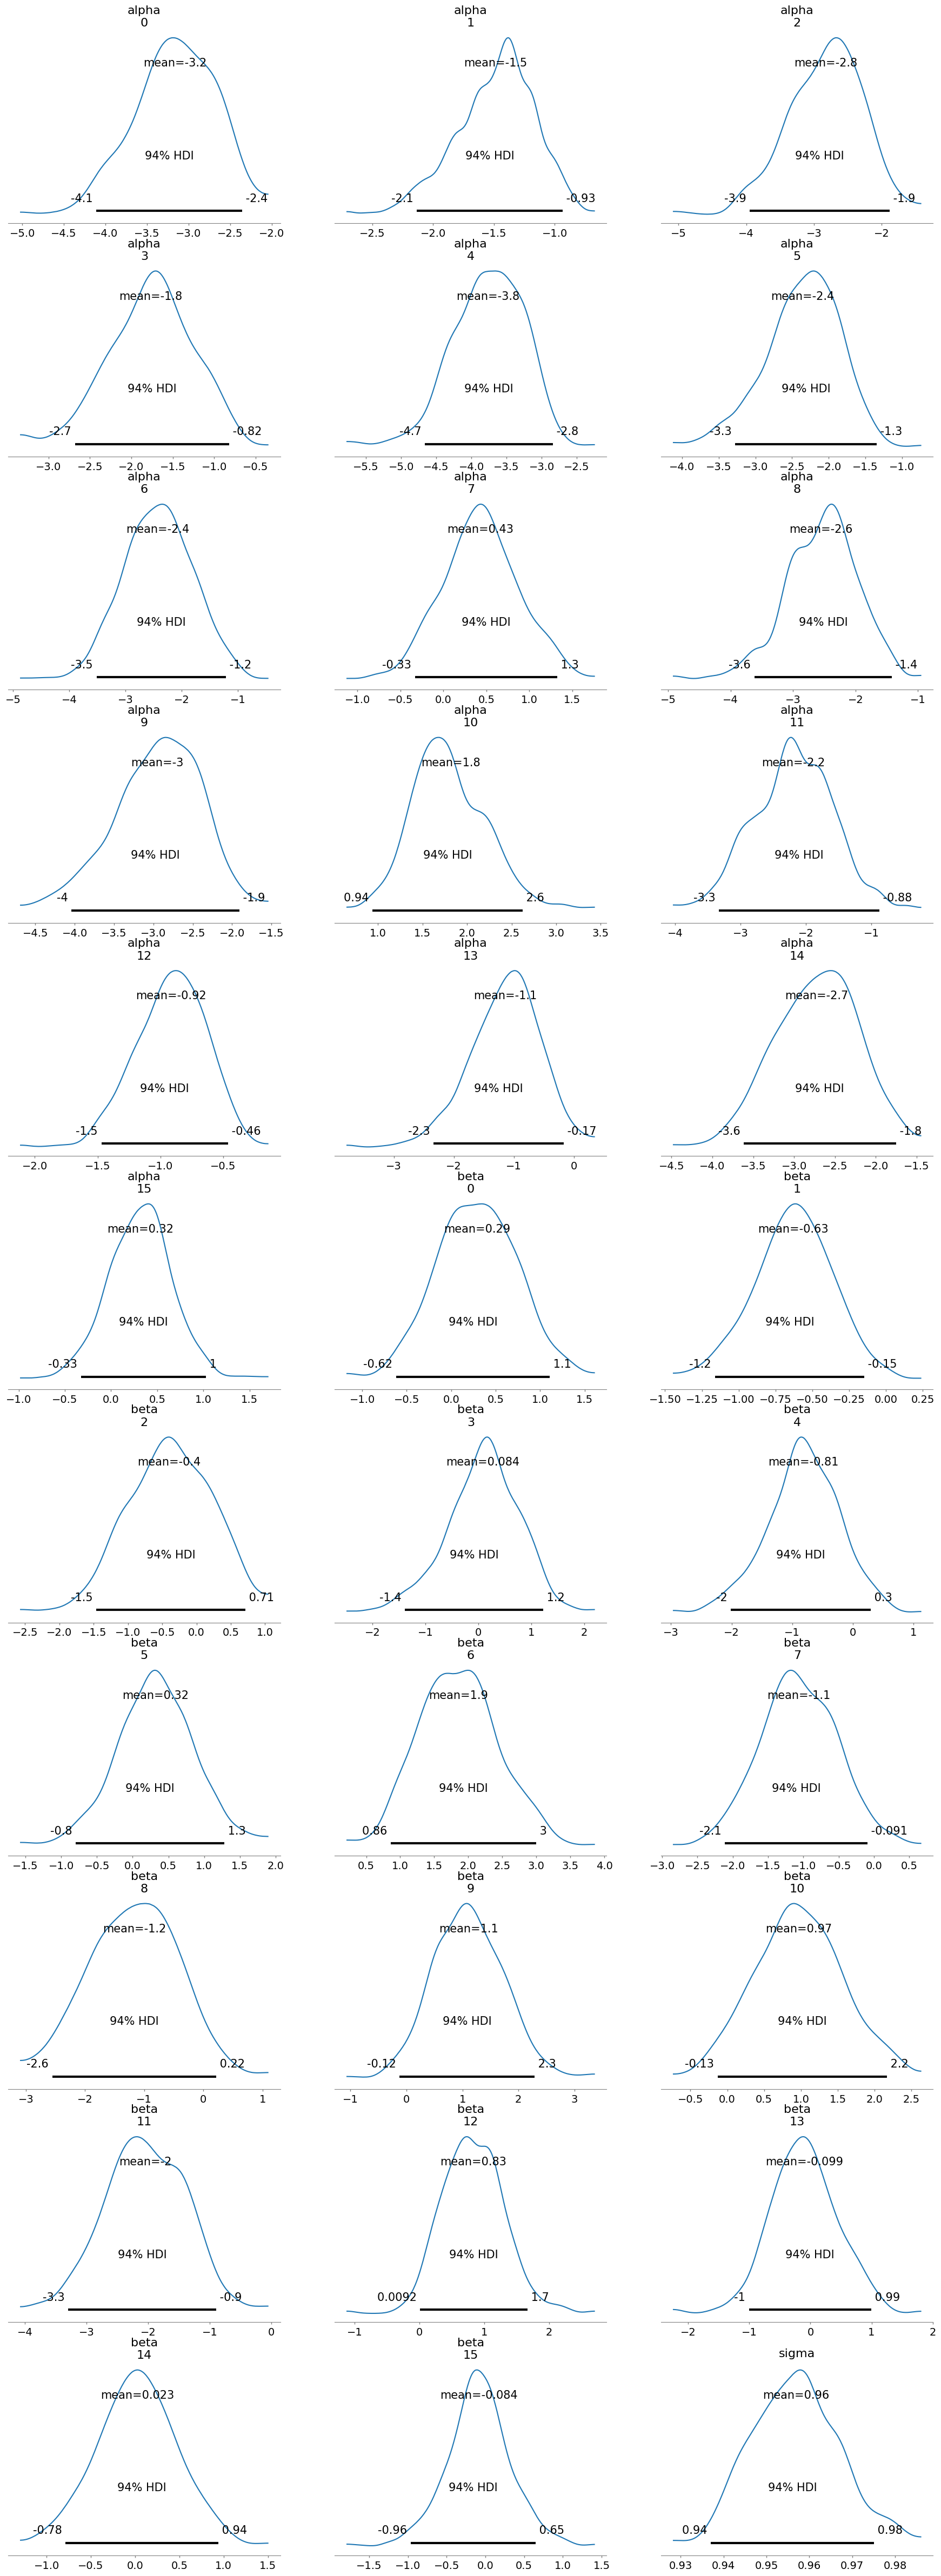

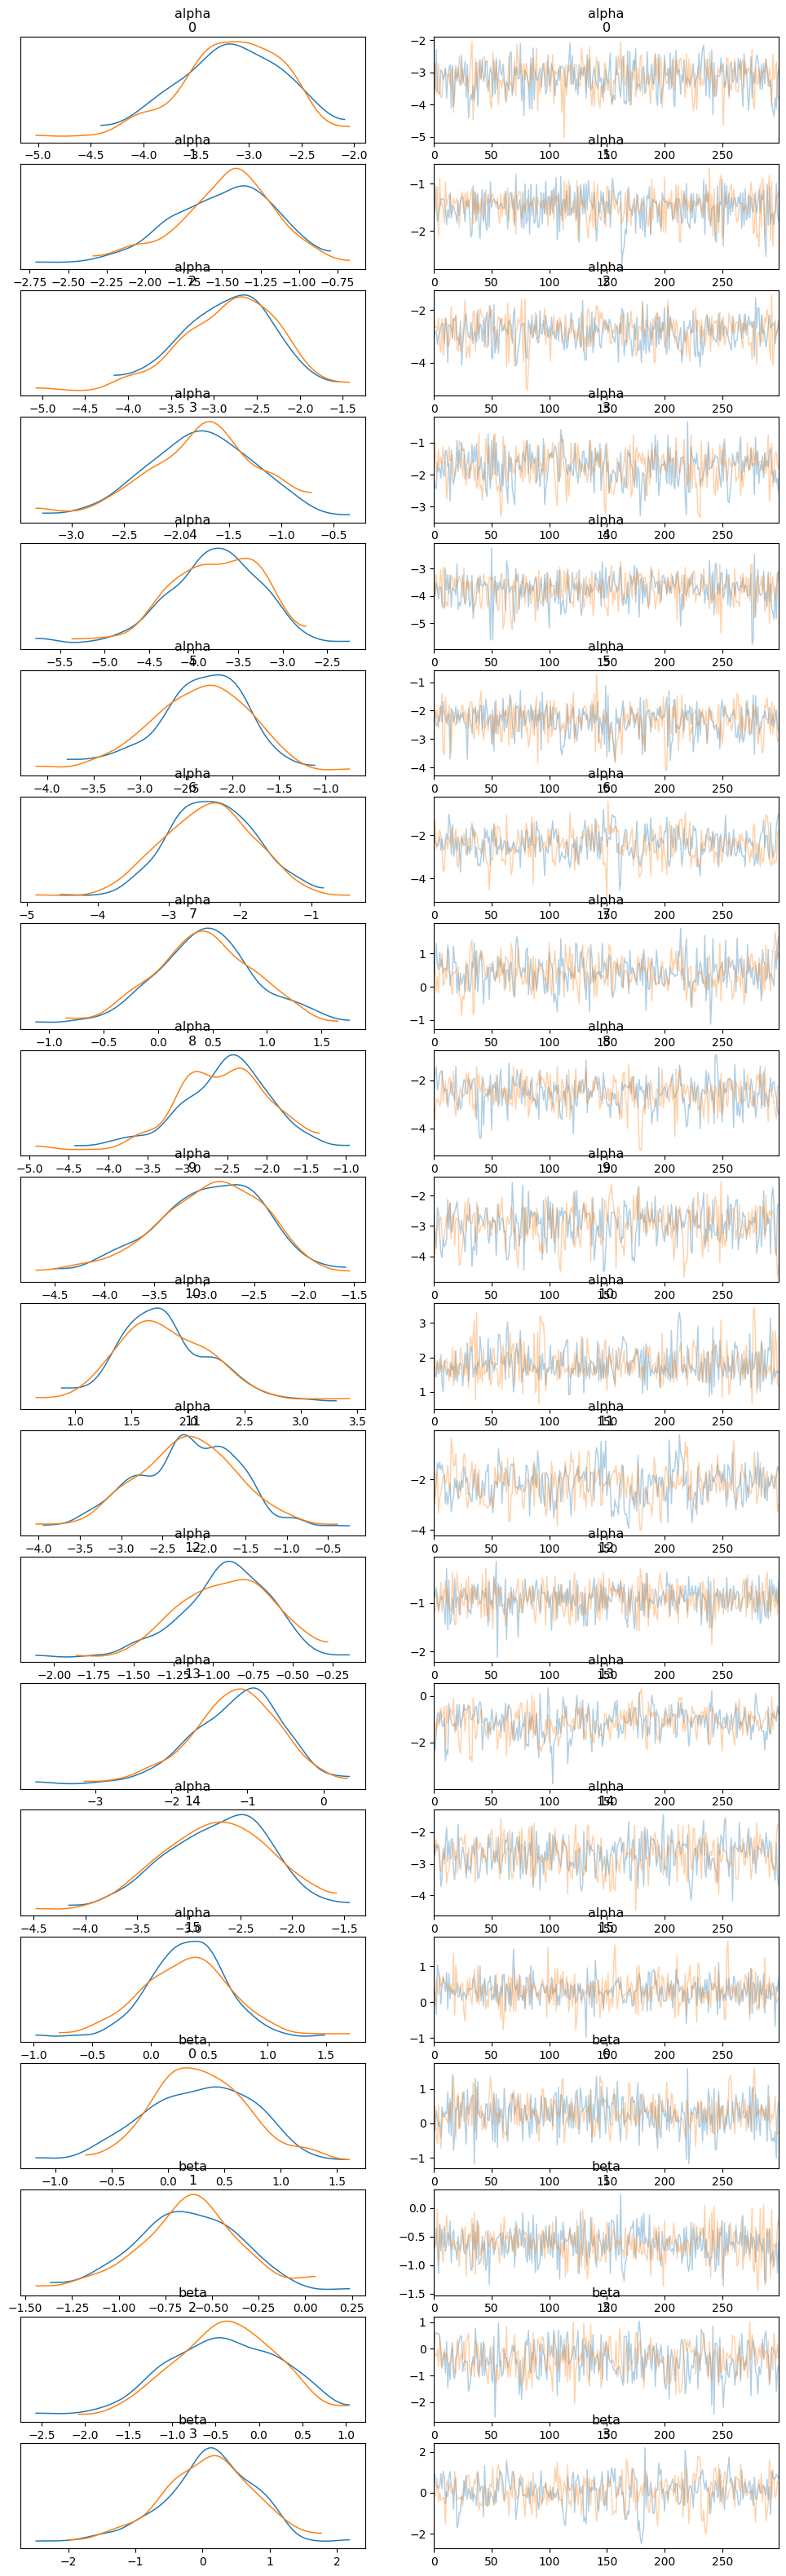

In [ ]:
 # model on real data
with pm.Model() as real_model:
    alpha = pm.Normal("alpha", mu=0, sigma=1, shape=num_genres)
    beta = pm.Normal("beta", mu=0, sigma=1, shape=num_genres)
    sigma = pm.Exponential("sigma", 1)

    genre_idx_real = df["genre_id"].values.astype("int32")
    energy_real = df["energy_scaled"].values.astype("float32")
    pop_real = df["popularity_scaled"].values.astype("float32")

    mu_logit = alpha[genre_idx_real] + beta[genre_idx_real] * energy_real
    mu = pm.Deterministic("mu", pm.math.invlogit(mu_logit))

    y_obs = pm.Normal("popularity", mu=mu, sigma=sigma, observed=pop_real)
    real_trace = pm.sample(300, tune=100, return_inferencedata=True, random_seed=42)

# assess sampling quality
az.plot_posterior(real_trace, var_names=["alpha", "beta", "sigma"])
az.plot_trace(real_trace, compact=False)

In [ ]:
az.summary(real_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-3.161,0.485,-4.111,-2.353,0.019,0.016,654.0,497.0,1.00
alpha[1],-1.488,0.323,-2.133,-0.934,0.011,0.016,1065.0,466.0,1.00
alpha[2],-2.827,0.548,-3.948,-1.885,0.024,0.027,552.0,412.0,1.00
alpha[3],-1.767,0.513,-2.682,-0.818,0.025,0.021,462.0,410.0,1.00
alpha[4],-3.767,0.517,-4.661,-2.842,0.019,0.024,745.0,489.0,1.00
...,...,...,...,...,...,...,...,...,...
mu[4168],0.035,0.028,0.001,0.087,0.001,0.002,773.0,352.0,1.00
mu[4169],0.056,0.028,0.010,0.105,0.001,0.001,678.0,381.0,1.01
mu[4170],0.035,0.030,0.001,0.092,0.001,0.002,767.0,351.0,1.00
mu[4171],0.035,0.027,0.001,0.082,0.001,0.002,776.0,352.0,1.00


**Posterior Plots:**

The effect of energy on popularity varies across genres. The posterior distribution of the slope (beta) show that some genres have strong positive associations like beta 6 with a mean of 1.8 and a HDI of [0.86, 3]. There are others with negative associations like beta 1 with a mean of -1.2 with an HDI of [-1.2,-0.15]. There are also parameters like beta 3 whose HDI includes 0 so due to high uncertainty we can not state a clear effect of energy in those genres.

**Trace Plots:**

The trace plots for alpha and beta show well-mixed chains with the "hairy caterpillar" shape meaning the sample is properly exploring the posterior distribution. The samples from different chains overlap, are bell-shaped and there is no visible divergence or trend in the chains. This suggests the model covers well.

**Summary Table:**

The summary table confirms good sampling quality. All parameters have R-hat values about 1 (chains have converged), effective sample sizes for the distributions are above 400 (stable estimates) and Monte Carlo standard errors are low meaning the posterior estimates are stable.

**Were the priors chosen reasonable?**

After fitting the model, we revisited the priors to check if they were reasonable. The posterior values for beta (like 1.8 and -1.2) were all within the range allowed by our prior of ~N(0,0.5). This shows the prior was flexible and reasonable.


## **Posterior Predictive Check**

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


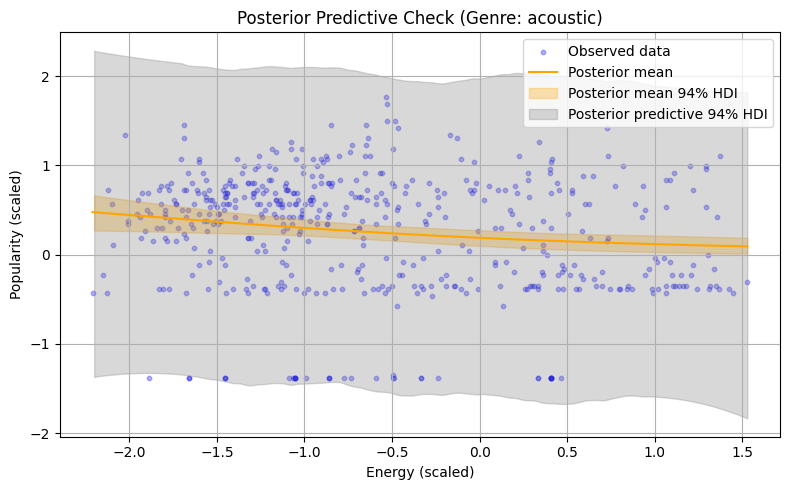

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


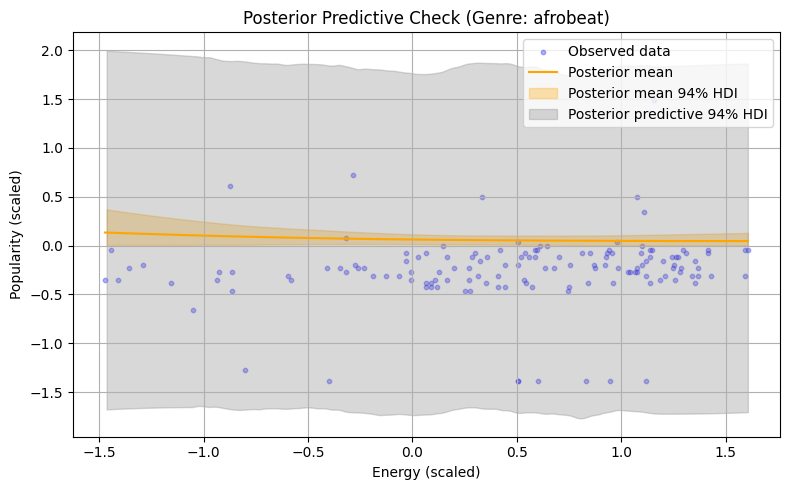

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


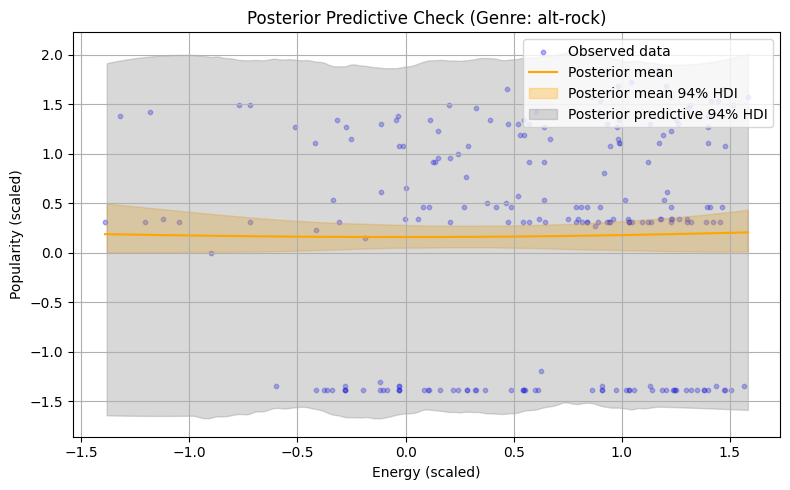

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


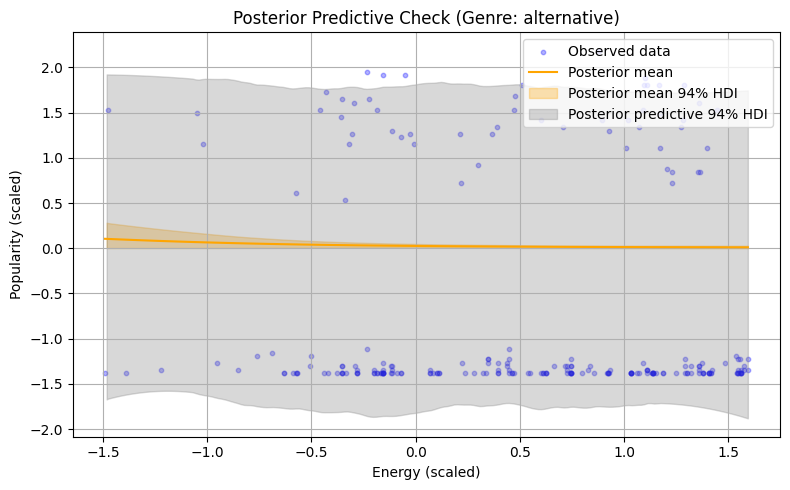

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


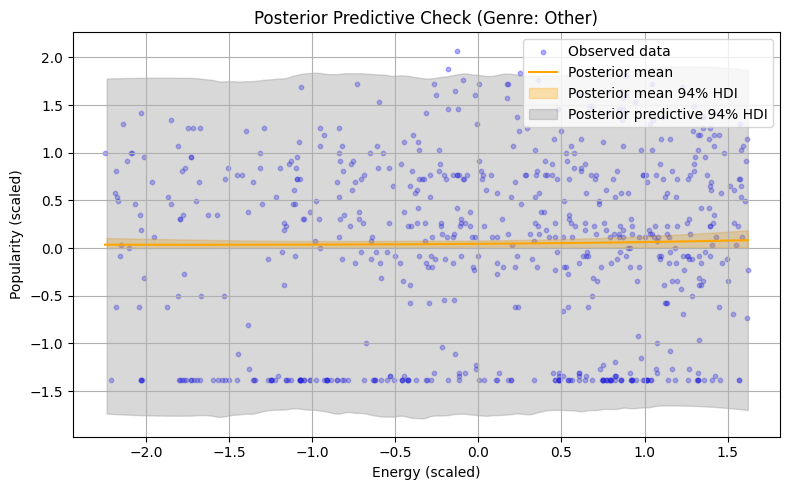

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


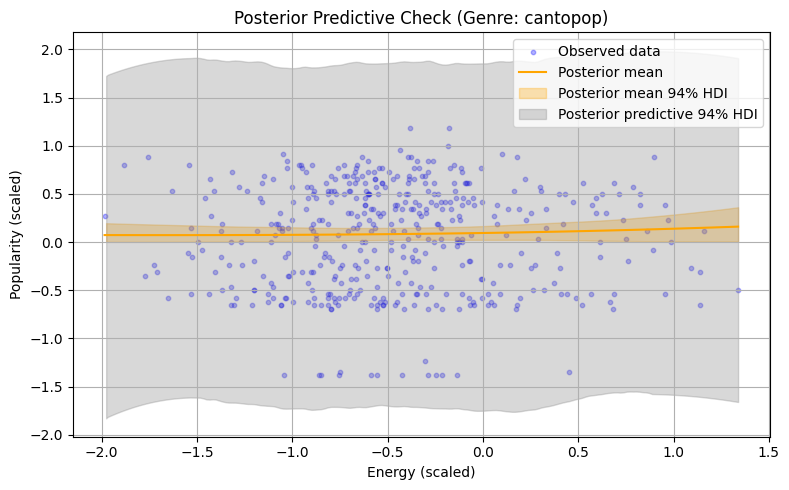

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


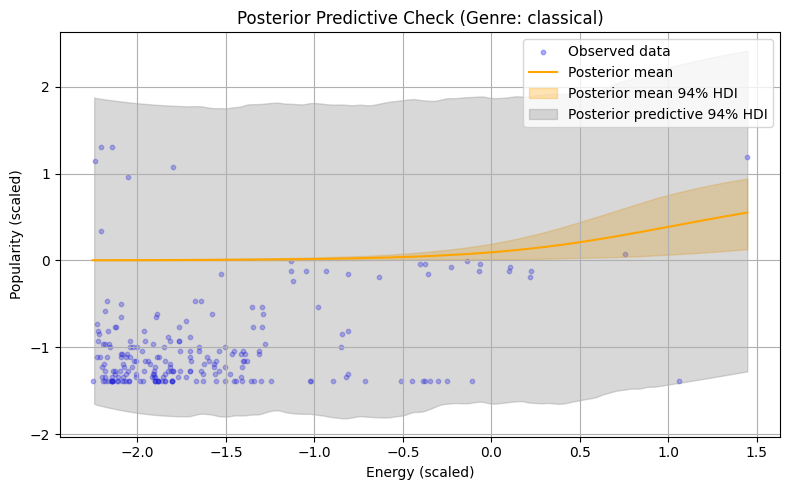

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


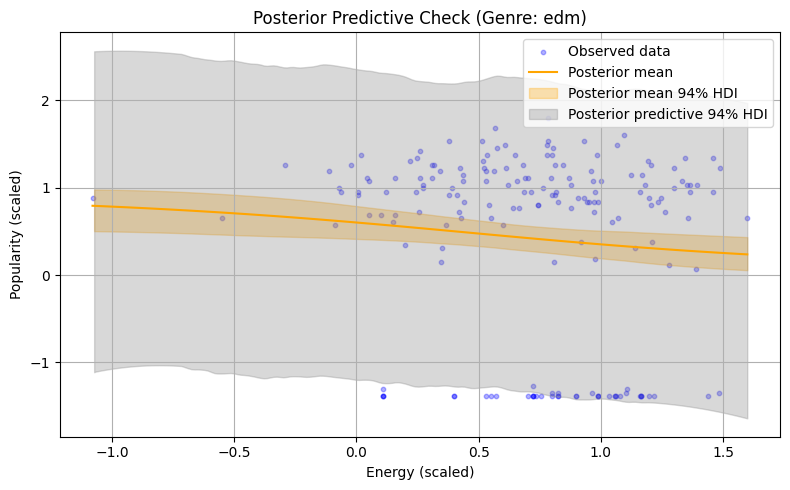

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


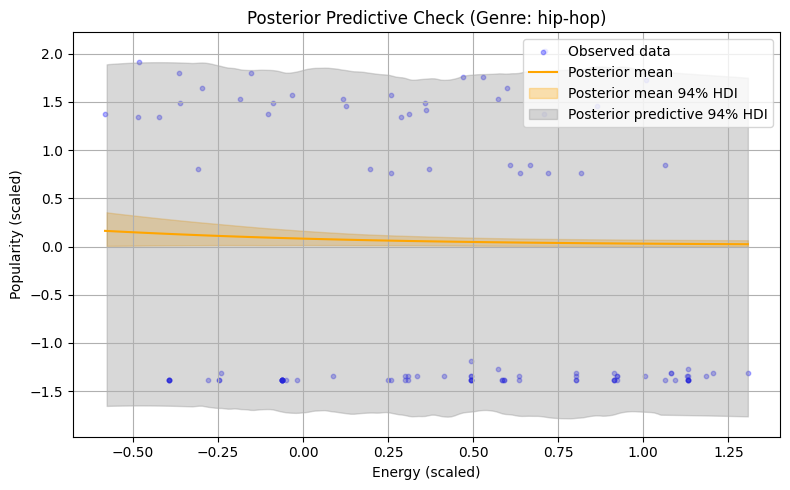

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


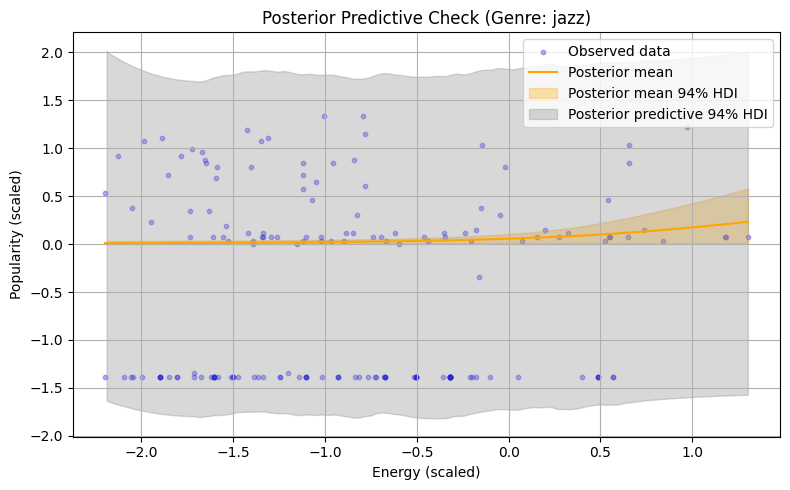

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


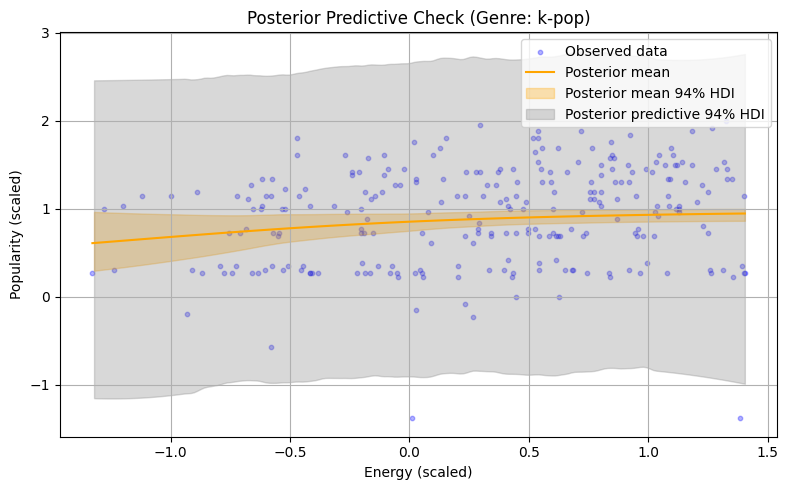

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


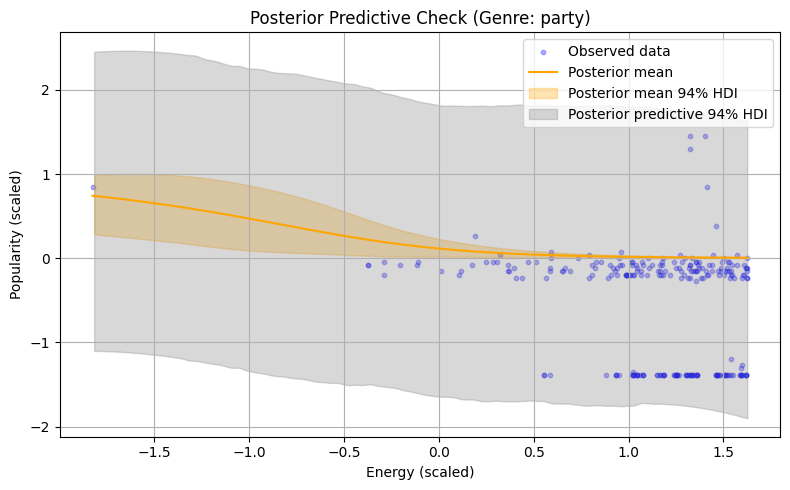

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


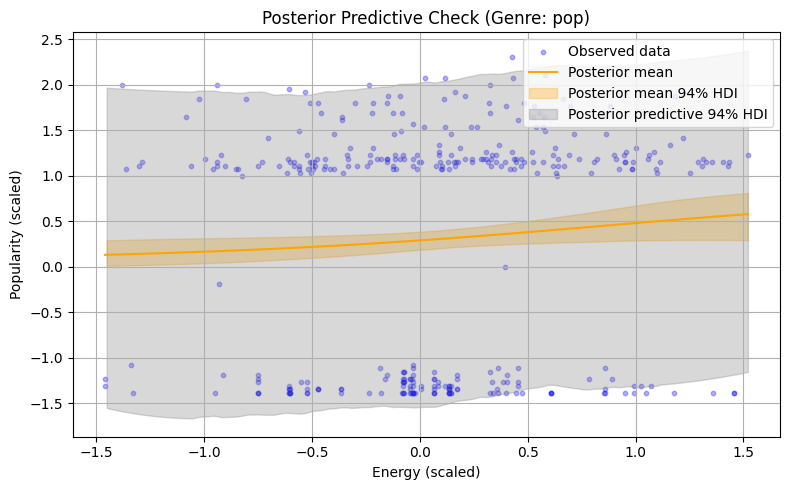

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


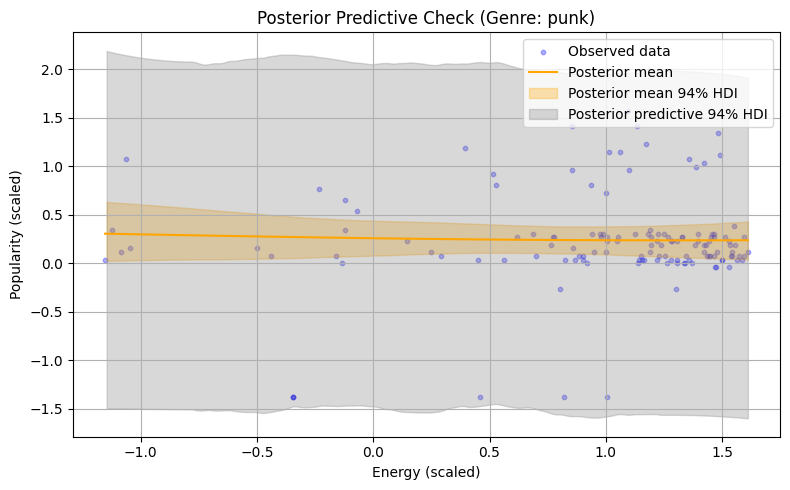

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


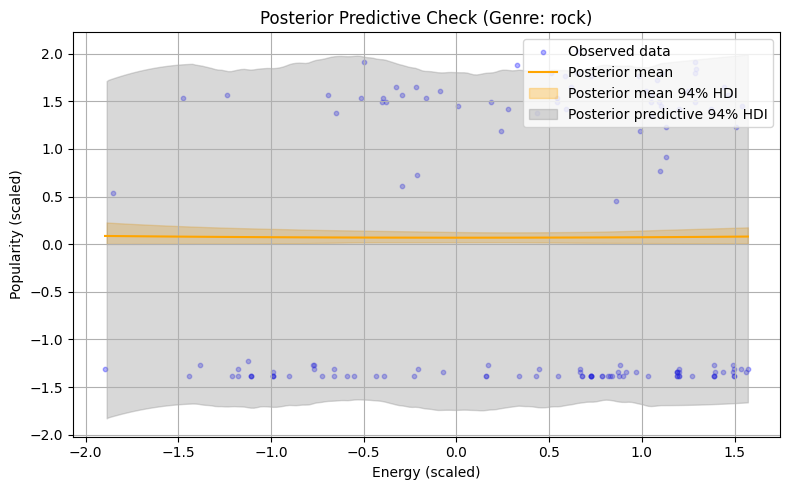

In [ ]:
# divide by genre, generate plot for each
unique_genres = df["genre_id"].unique()
genre_names = df["track_genre"].astype("category").cat.categories  # optional, for labeling

for g in unique_genres:
    # Mask for current genre
    mask = df["genre_id"] == g
    x_g = energy_real[mask]
    y_g = pop_real[mask]

    # Get genre-specific alpha and beta samples
    a_samples = real_trace.posterior["alpha"][:, :, g].stack(sample=("chain", "draw")).values
    b_samples = real_trace.posterior["beta"][:, :, g].stack(sample=("chain", "draw")).values

    # Prediction across x sequence
    x_seq = np.linspace(x_g.min(), x_g.max(), 100)
    mu_pred = np.array([pm.math.invlogit(a + b * x_seq).eval() for a, b in zip(a_samples, b_samples)])
    mu_mean = mu_pred.mean(axis=0)

    # Posterior predictive samples
    sigma = real_trace.posterior["sigma"].stack(sample=("chain", "draw")).mean().values
    ppc_samples = np.random.normal(mu_pred, sigma)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(x_g, y_g, alpha=0.3, s=10, color="blue", label="Observed data")
    plt.plot(x_seq, mu_mean, color="orange", label="Posterior mean")

    az.plot_hdi(x_seq, mu_pred, color="orange", hdi_prob=0.94,
                fill_kwargs={"alpha": 0.3, "label": "Posterior mean 94% HDI"})

    az.plot_hdi(x_seq, ppc_samples, color="gray", hdi_prob=0.94,
                fill_kwargs={"alpha": 0.3, "label": "Posterior predictive 94% HDI"})

    plt.xlabel("Energy (scaled)")
    plt.ylabel("Popularity (scaled)")
    plt.title(f"Posterior Predictive Check (Genre: {genre_names[g]})")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()




**Discussion of Posterior Predictive Check Result:**

The plot displays the model’s posterior predictive check using scaled energy as the predictor of popularity within each genre. Blue points represent observed data. The orange curve shows the posterior mean prediction, with the orange band indicating the 94% highest density interval (HDI), representing uncertainty around the mean. The gray band reflects the uncertainty of the full posterior predictive distribution.

The posterior mean curves vary across genres, with differing slopes that suggest the influence of energy on popularity is genre-dependent. For instance, the K-pop plot shows a positive slope, indicating that higher energy levels are linked to greater popularity. In contrast, the acoustic genre displays a negative slope, suggesting that increased energy corresponds to lower popularity.

Overall, the observed data fall largely within the posterior predictive intervals, indicating that the model fits the data well. The posterior mean captures the general trend, while the credible intervals reflect the variability and noise in the observations. This alignment suggests the posterior approximation is accurate and the model is well-calibrated for the data.




## **FINAL DISCUSSION**

This analysis aimed to examine the relationship between a song's energy and its popularity, while accounting for genre as a potential confounder to assess how this relationship varies across genres.
* *What's learned from the model:*
Our model explores the relationship between energy and popularity across genres by stratifying on genre. The posterior predictive checks reveal that the effect of energy on popularity varies by genre. For example, in K-pop, higher energy is associated with greater popularity, whereas in acoustic music, higher energy tends to reduce popularity. This aligns with intuition: listeners often seek high-energy experiences in K-pop, while preferring smoother, more relaxed sounds in acoustic music.


* *The effect of confounding variable:*
The model incorporates genre-specific parameters, enabling the estimation of distinct baseline popularity levels (α) and energy-popularity relationships (β) for each genre. This adjustment is essential because genre can independently influence both a song’s energy level and its popularity, as shown in the β parameter plot and the posterior predictive check plots by genre. Some genres exhibit positive correlations, while others show negative relationships, and the strength of these effects varies across genres. Without controlling for genre, estimates of the effect of energy on popularity could be biased and misleading.


* *Evidence Supported:*
The primary conclusion—that the relationship between energy and popularity varies across genres—is strongly supported by the posterior distributions of the beta parameters and the posterior predictive checks. These distributions quantify the energy-popularity relationship within each genre. The close alignment between model predictions and observed data indicates that the posterior approximation is reasonably accurate and the model is well-calibrated for the dataset. Evidence for the choice of a Normal distribution to represent the outcome variable is reasonable is backed up by the observed data. The posterior predictive check shows that the observed popularity values are symmetrically distributed and concentrated around the model’s posterior mean represented by the orange band, with fewer points farther from the mean. Above and below the orange band, there are decreasing amounts of observations that take on the shape of a normal distribution.


* *Possible future expand:* The current model results provide a strong foundation for future, more in-depth analyses. The most prominent finding—the variability in the energy-popularity relationship across genres—directly suggests several key directions:

  * Further analysis could investigate how energy interacts with other song features to influence popularity within each genre. For instance:
  Does the effect of energy depend on the song's danceability or valence?
  * Another interesting direction would be to investigate how the energy-popularity relationship evolves over time within different genres. For example, do high-energy songs become more or less popular in a genre as it matures?







**Summary of group participation**

Group Members:

Member 1: Alicia Tian

Member 2: Kaitlyn Huynh

Member 3: Pari Patel

**Proposal Contributions:**

All members contributed equally to brainstorming and outlining the proposal.

**Final Write-up Contributions:**

Data Preprocessing: Kaitlyn Huynh, Alicia Tian, Pari Patel

Causal Model: Kaitlyn Huynh

Prior Predictive Simulation: Pari Patel, Kaitlyn Huynh

Posterior on simulated data: Pari Patel, Kaitlyn Huynh

Posterior on Real Data: Alicia Tian, Pari Patel

Posterior Predictive Check: Alicia Tian

Discussion: Alicia Tian, Kaitlyn Huynh

